# Regularization

Fit a regression with some limitations on the coefficients making it somewhat resistent to overfitting

## Example 1. Regularization with artifical data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pylab as plt
import math
import seaborn as sbn
%matplotlib inline

In [2]:
#generate random data repeating regressors with minor fluctuations
M = 20
np.random.seed(1)

X = pd.DataFrame(np.random.randn(3*M,3))
Y = X.sum(axis = 1) + np.random.randn(3*M) #add a random target variable as a sum of three of the features and some noise
data = pd.concat([Y,X]+[X+0.01*np.random.randn(3*M,3) for i in range(4)], axis = 1)  # concatenate Y and X
data.columns = ['Y'] + ['x%d'%(i+1) for i in range(data.shape[1]-1)]         # rename the columns
dataTrain=data.iloc[:M,:]
dataTest=data.iloc[M:2*M,:]
dataValid=data.iloc[2*M:,:]

In [4]:
dataTrain.head()

,Y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,-0.788142,1.624345,-0.611756,-0.528172,1.619363,-0.614866,-0.528191,1.622058,-0.595623,-0.531920,1.613616,-0.606805,-0.537692,1.631123,-0.622822,-0.531764
1,-2.195552,-1.072969,0.865408,-2.301539,-1.086935,0.856794,-2.294792,-1.080468,0.885954,-2.301005,-1.078150,0.850794,-2.306702,-1.067915,0.877587,-2.320946
2,1.805829,1.744812,-0.761207,0.319039,1.750997,-0.765639,0.337144,1.740020,-0.757705,0.319211,1.748323,-0.761895,0.305561,1.736750,-0.760716,0.313078
3,0.445823,-0.249370,1.462108,-2.060141,-0.262428,1.458658,-2.062449,-0.253662,1.474193,-2.048984,-0.234663,1.465480,-2.050060,-0.240754,1.441244,-2.056523
4,0.316851,-0.322417,-0.384054,1.133769,-0.350348,-0.364679,1.137433,-0.314009,-0.385083,1.145238,-0.314565,-0.390703,1.114319,-0.318158,-0.383564,1.144792


In [5]:
#perform a regression of the target variable against those three features we used to compute it
lm = smf.ols(formula = 'Y ~ x1+x2+x3', data = dataTrain).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     17.79
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           2.38e-05
Time:                        12:43:09   Log-Likelihood:                -23.431
No. Observations:                  20   AIC:                             54.86
Df Residuals:                      16   BIC:                             58.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3465      0.197      1.757      0.0

R2 is somewhat high and the coefficient estimates are relatively close to the original ones we used - confidence intervals include 1; some deviations might be attributed to adding substantial noise to the target variable

In [11]:
'+'.join(dataTrain.columns[1:])

'x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15'

Can we do better if we add other features? Although we know they are random and target variable has little to do with them...

In [7]:
lm2 = smf.ols(formula = 'Y ~ '+ '+'.join(dataTrain.columns[1:]), data = dataTrain).fit()
OLS_coef=lm2.params
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3.715
Date:                Tue, 29 Oct 2019   Prob (F-statistic):              0.107
Time:                        12:43:28   Log-Likelihood:                -11.065
No. Observations:                  20   AIC:                             54.13
Df Residuals:                       4   BIC:                             70.06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1937      0.608      0.318      0.7

R2 increased, but neither p-value nor coefficient estimates make much sense now.

Perfect case of multicollinearity and likely overfitting!

In [12]:
from sklearn.metrics import r2_score

In [13]:
#indeed the test R2 is negative this way
r2_score(dataTest.Y,lm2.predict(dataTest))

-0.892708496099802

How can we see from the regression itself that smth is wrong? Let's look at the coefficients having pretty hight magnitude compared to the original scale of the data

In [ ]:
lm2.params

# Idea of regularization

When fitting a linear regression with multiple features $x=(x^1,x^2,...,x^n)$ 
$$
y\sim w^T x
$$
the model might become complex and susceptible to overfitting. Complexity often comes with coefficients $w$ growing large in absolute values.

One way to reduce complexity is to penalize regression for the magnitude of the coefficients $w=(w^1,w^2,...,w^n)$, which can be measured by
$$
||w||_1=\sum\limits_j |w^j|
$$
or by 
$$
||w||_2^2=\sum\limits_j (w^j)^2
$$
So instead of simply minimizing 
$$
RSS(w)=\sum\limits_j (y_j-w^T x_j)^2
$$
where $x_j, y_j$ are observations for regressors and output variable, we minimize
$$
RSS(w)+\lambda ||w||_2^2=RSS(w)+\lambda \sum\limits_j (w^j)^2\to\min\hspace{10ex}(Ridge)
$$
or
$$
RSS(w)+\lambda ||w||_1=RSS(w)+\lambda \sum\limits_j \left|w^j\right|\to\min\hspace{10ex}(Lasso)
$$

The first model is known as Ridge, the second - as Lasso (least absolute shrinkage and selection operator) regularized regression.

Both Ridge and Lasso could be shown to be equivalent to a constrained minimization of $RSS$:

$$
RSS(w)\to min, \ ||w||_p\leq \alpha,
$$

with $p=1,2$ respectively, although analytic relation between constants $\alpha$ and $\lambda$ is somewhat nontrivial. In practice however the choice of $\lambda$ or $\alpha$ is usually empirical anyway, so both regularized or constrained forms of the optimization problem are equally applicable.

Optimization problems (Ridge) and (Lasso) tend to minimize $RSS$ at the same time penalizing the regression for having $||w||$ too large (regularization) which often leads to the model complexity through multiple regressors with large coefficients canceling effect of each other. So in a sense Lasso and Ridge are trying to avoid this situation, looking for relatively simple "regular" models with best possible fit. 

** NOTICE ** As the order of magnitude of $w^j$ is directly related to the scale of the regressors, it is practical to rescale them (e.g. by standardizing) to make sure the $w^j$ are comparable in scale. Otherwise penalization terms directly mixing components $w^j$ of different, sometimes incomparable, scale do not make too much sense.

From Bayesian standpoint (for those familiar with Bayesian inference) Lasso and Ridge simply perform the regression with the prior belief that all the components of the $w$ are limited through the fixed variance of the priors. Such a belief affects the final outcome of the model making solutions with large $||w||$ to be particularly unlikely.

This helps Ridge and Lasso to fight overfitting also dealing with multicollinearity of regressors to some extent, preventing from learning noise through particularly complex "unnatural" combinations of the regressors.

Ridge regression admits solution in the closed form (consider partial derivatives of the objective function with respect to $w_j$):

$$
\hat{w}=(X^T X+\lambda I)^{-1}X^T Y, \hspace{5ex}(Ridge\ solution)
$$

where $I$ is the identity $n\times n$ matrix, while $n$ being the number of regressors. The formulae (Ridge solution) shows that the Ridge regression can in theory deal with the case of multicollinearity, when the matrix $X^T X$ is singular and OLS estimate does not exist.

Lasso does not admit solution in the closed form and requires numerical methods (like subgradient methods) to be fit. 
Lasso however has an advantage of being often able to completely eliminate impact of certain irrelevant regressors setting the corresponding slope coefficients to zero.  

### Validation and cross-validation

A good way to evaluate the model is to use a test set separate from the training sample to estimate the model performance. Additionally if the model depends on the certain parameters (like $\alpha,\lambda$ for Lasso/Ridge) which are not supposed to be fit during the training phase, a separate validation sample could be used for the selection of model parameters (we pick up those which optimize model performance over the validation set). Usually test and validation sets are got as subsamples (often random) of the available dataset, while the remaining data is used as the training sample. 

But often the available dataset is small enough, so splitting into into even smaller traning, validation and test sets could have negative impact on the model training leading to noisy and unreliable models. In such cases cross-validation is often applied, performing not one but several random splits of the sample with further averaging of the model performance scores. 

## Choice of $\lambda$ or $\alpha$. Model validation.

In both - constrained and regularized forms - the parameter $\alpha$ or $\lambda$ of Lasso/Ridge regression is somewhat arbitrary and can take any value from $0$ to $+\infty$. Small values of $\lambda$ or high values of $\alpha$ lead to the result close to OLS (identical to it is $\lambda=0$ or $\alpha=+\infty$), while large $\lambda$ or small $\alpha$ tend to overemphasize the impact of regularization over the fit itself. There is no single best way of choosing the value of the regularization parameter - what is usually suggested is to fit it by evaluating the model for different values of the parameter over the separate validation set and picking up the value for which the validation performance is the best one. As for the performance metric one can use RSS or, equivalently, R2.

In [24]:
#try Ridge with an arbitrary regularization parameter alpha=1
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Ridge.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Ridge is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
Ridge.coef_

The IS R-squared of Ridge is: 0.769666378885


array([0.1896624 , 0.24722858, 0.18132605, 0.21763589, 0.24170847,
       0.17970417, 0.15691973, 0.22943271, 0.11503989, 0.19477322,
       0.28970272, 0.23323684, 0.19730613, 0.2294736 , 0.19280885])

In [25]:
#Out of sample
YPred_OS=Ridge.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Ridge is: {0}".format(r2_score(dataTest.Y,YPred_OS)))

The OS R-squared of Ridge is: 0.343116985185


In [42]:
#try Lasso with an another arbitrary regularization parameter alpha=0.01 (if we try alpha=1 this turns out to be too much regularization already)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.1)

Lasso.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Lasso.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataTest.Y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.754518029137
The OS R-squared of Lasso is: 0.41632294785


array([0.        , 0.        , 0.        , 0.80668997, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.02567708, 0.81067886, 0.        , 0.        , 0.        ])

In [43]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

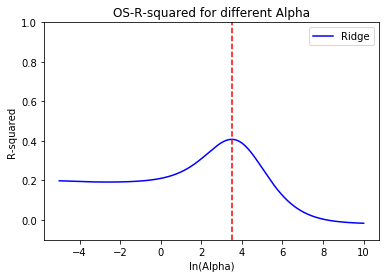

Optimal alpha for Ridge=33.1601924859, best OS R_2=0.408170339419


In [51]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,dataTrain.iloc[:,1:],dataTrain.Y,dataValid.iloc[:,1:],dataValid.Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

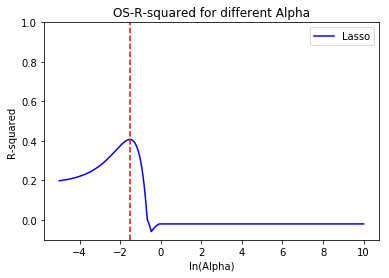

Optimal alpha for Lasso=0.218788019548, best OS R_2=0.407976931817


In [52]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,dataTrain.iloc[:,1:],dataTrain.Y,dataValid.iloc[:,1:],dataValid.Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [53]:
#now consider the test sample performanc of the best Lasso model and its coefficients

In [54]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Lasso.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataTest.Y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.679858173615
The OS R-squared of Lasso is: 0.451936835654


array([0.        , 0.        , 0.        , 0.41519791, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.72985833, 0.68059909, 0.19852351, 0.        , 0.        ])

## Example 2. Recall the polynomial regression from previous class and try lasso for degree selection

In [55]:
#generate data and put it in the dataframe
np.random.seed(2018)
x=np.arange(-10,20,0.5)
y=x**4/100+x**3/20+x**2/3+2*x+np.random.normal(loc=0,scale=3,size=60)
data2=pd.DataFrame({'x':x,'y':y}) #create a dataframe
#slice the data in three pieces (we'll talk about those later)
data2.head() #for now let's stick with this first one

,x,y
0,-10.0,62.503031
1,-9.5,51.410761
2,-9.0,44.605198
3,-8.5,24.739247
4,-8.0,22.200164


In [56]:
data2 = data2.reindex(['y','x'], axis=1)

In [57]:
M=10
for p in range(1,M+1): #add more powers of x up to 10'th
    data2['x%d'%p]=data2.x**p
data2.head()

,y,x,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,62.503031,-10.0,-10.0,100.00,-1000.000,10000.0000,-100000.00000,1000000.000000,-1.000000e+07,1.000000e+08,-1.000000e+09,1.000000e+10
1,51.410761,-9.5,-9.5,90.25,-857.375,8145.0625,-77378.09375,735091.890625,-6.983373e+06,6.634204e+07,-6.302494e+08,5.987369e+09
2,44.605198,-9.0,-9.0,81.00,-729.000,6561.0000,-59049.00000,531441.000000,-4.782969e+06,4.304672e+07,-3.874205e+08,3.486784e+09
3,24.739247,-8.5,-8.5,72.25,-614.125,5220.0625,-44370.53125,377149.515625,-3.205771e+06,2.724905e+07,-2.316169e+08,1.968744e+09
4,22.200164,-8.0,-8.0,64.00,-512.000,4096.0000,-32768.00000,262144.000000,-2.097152e+06,1.677722e+07,-1.342177e+08,1.073742e+09


In [58]:
data2_Valid=data2.loc[40:49]
data2_Test=data2.loc[50:59]
data2_Train=data2.loc[0:39] 

In [59]:
import warnings
warnings.filterwarnings('ignore')

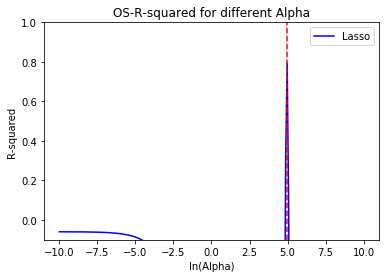

Optimal alpha for Lasso=144.730641765, best OS R_2=0.792822182006


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.25976199e-02,
        1.68990266e-02,  1.60895306e-03,  3.53094156e-05, -2.17197707e-05,
       -1.22839950e-06,  6.85886212e-08,  4.65240523e-09])

In [60]:
alphas = np.exp(np.linspace(-10,10,200)) #exponential range of possible alphas
[alpha_optimal, best_R2, Lasso_coefs]=Regularization_fit_alpha(2,data2_Train.iloc[:,1:],data2_Train.y,data2_Valid.iloc[:,1:],data2_Valid.y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Lasso_coefs

In [61]:
#counter to our expectations the model eliminated lower powers, not the higher ones...

In [62]:
#what about test sample performance? not good despite good validation R2
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(data2_Train.iloc[:,1:],data2_Train.y)
# In sample:
YPred_IS=Lasso.predict(data2_Train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(data2_Train.y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(data2_Test.iloc[:,1:])
print("The test R-squared of Lasso is: {0}".format(r2_score(data2_Test.y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.989554201993
The test R-squared of Lasso is: -733.386396016


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.25976199e-02,
        1.68990266e-02,  1.60895306e-03,  3.53094156e-05, -2.17197707e-05,
       -1.22839950e-06,  6.85886212e-08,  4.65240523e-09])

The problem is the scale of the data! Regularization applies the same magnitude criteria to all the coefficients. While in case of the polynomial regression, regressors (powers of x) have totally different scale and so do the coefficients. What to do about it? 

#### We always need to bring regressors on the same scale (normalize) before applying regularization!!!

In [64]:
#learn standardization parameters from training set
mu=data2_Train.iloc[:,1:].mean()
sigma=data2_Train.iloc[:,1:].std()

In [ ]:
#and apply standardization to all - training, validation and test 
#although sometimes done that way, strictly speaking it won't be appropriate to scale the entire dataset or
#scale validation and test directly;
#as scaling just like any other model should be trained over training only!
#besides we might want to have scaling model consistent over the entire dataset

In [65]:
data2_Train.iloc[:,1:]=(data2_Train.iloc[:,1:]-mu)/sigma

In [66]:
data2_Valid.iloc[:,1:]=(data2_Valid.iloc[:,1:]-mu)/sigma

In [67]:
data2_Test.iloc[:,1:]=(data2_Test.iloc[:,1:]-mu)/sigma

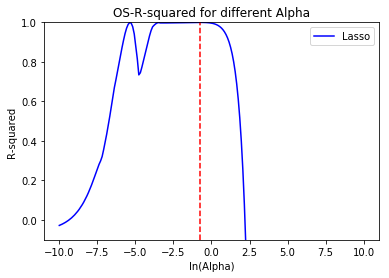

Optimal alpha for Lasso=0.470589627369, best OS R_2=0.999705724847


array([10.40647093,  0.        , 10.76712933, 19.86428381, 26.8587792 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [68]:
#now train Lasso and pick up the best alpha for it using the scaled data 
alphas = np.exp(np.linspace(-10,10,200)) #exponential range of possible alphas
[alpha_optimal, best_R2, Lasso_coefs]=Regularization_fit_alpha(2,data2_Train.iloc[:,1:],data2_Train.y,data2_Valid.iloc[:,1:],data2_Valid.y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Lasso_coefs

In [69]:
#so now the model looks about right

In [70]:
#what about test sample performance now? much better!
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(data2_Train.iloc[:,1:],data2_Train.y)
# In sample:
YPred_IS=Lasso.predict(data2_Train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(data2_Train.y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(data2_Test.iloc[:,1:])
print("The test R-squared of Lasso is: {0}".format(r2_score(data2_Test.y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.996382740212
The test R-squared of Lasso is: 0.999954846764


array([10.40647093,  0.        , 10.76712933, 19.86428381, 26.8587792 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])